In [ ]:
from pathlib import Path

import mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
rawdata_dir = Path("../rawdata")
participants_tsv = pd.read_csv(rawdata_dir / "participants.tsv", sep="\t")

In [ ]:
participants_tsv

,participant_id,age,dementia,ad,load,eoad,vd,sivd,ad_vd_mixed,mci,...,parkinson_dementia,nph,tga,dementia_type,dementia_label,normality_label,dementia_split,dementia_split_no_overlap,normality_split,normality_split_no_overlap
0,1,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,mci,abnormal,test,test,train,train
1,2,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,normal,normal,train,train,train,train
2,3,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,mci,abnormal,train,train,train,train
3,4,78,True,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ad,dementia,abnormal,test,NaN,train,train
4,5,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,mci,abnormal,train,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1384,57,True,True,NaN,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ad,dementia,abnormal,train,train,train,train
1375,1385,77,True,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ad,dementia,abnormal,train,train,train,train
1376,1386,80,True,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ad,dementia,abnormal,train,train,train,train
1377,1387,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,mci,abnormal,test,test,val,val


## Age Distribution

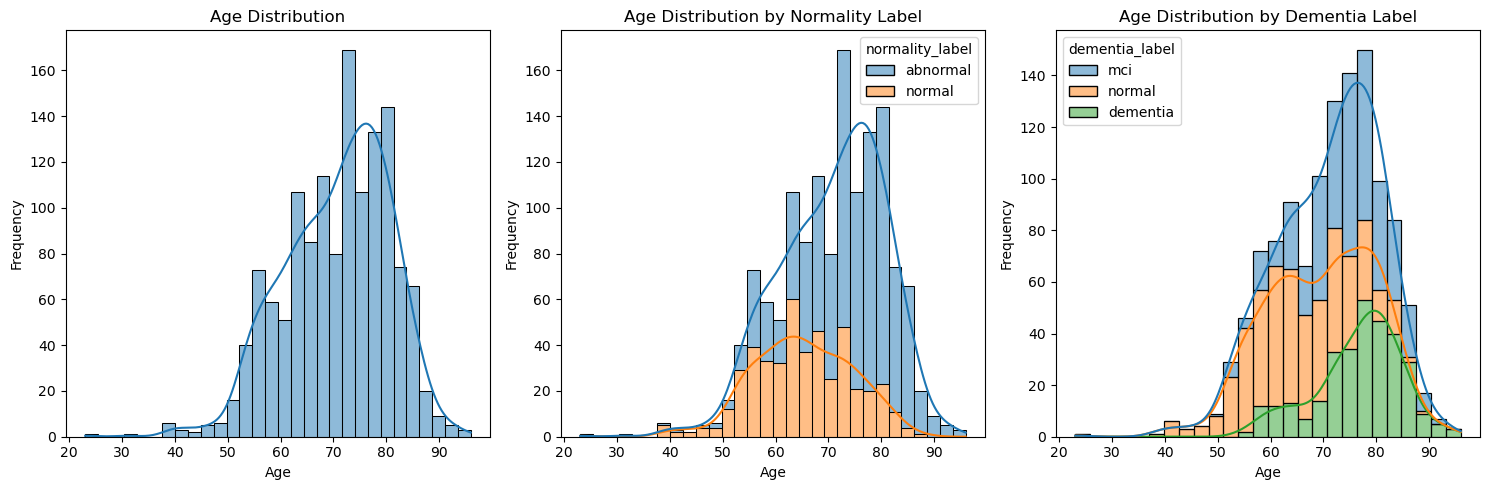

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot age distribution
sns.histplot(data=participants_tsv, x='age', kde=True, multiple='stack', ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot age distribution by normality_label
sns.histplot(data=participants_tsv, x='age', hue='normality_label', kde=True, multiple='stack', ax=axes[1])
axes[1].set_title('Age Distribution by Normality Label')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

# Plot age distribution by dementia_label
sns.histplot(data=participants_tsv, x='age', hue='dementia_label', kde=True, multiple='stack', ax=axes[2])
axes[2].set_title('Age Distribution by Dementia Label')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The age distributions show clear differences between the normality_label and dementia_label groups. 

## Train-val-test Splits

In [ ]:
# Count the number of normal and abnormal recordings for each split in normality_split_no_overlap
temp = participants_tsv.copy()
temp['normality_split_no_overlap'] = pd.Categorical(
    temp['normality_split_no_overlap'], 
    categories=['train', 'val', 'test'], 
    ordered=True
)
split_counts = temp.groupby(['normality_split_no_overlap', 'normality_label'], observed=True).size().unstack()
print(split_counts)

normality_label             abnormal  normal
normality_split_no_overlap                  
train                            740     367
val                               73      32
test                              72      37


In [ ]:
# Count the number of normal and abnormal recordings for each split in normality_split_no_overlap
temp = participants_tsv.copy()
temp = temp[temp.dementia_split_no_overlap.notna()]
temp['dementia_split_no_overlap'] = pd.Categorical(
    temp['dementia_split_no_overlap'], 
    categories=['train', 'val', 'test'], 
    ordered=True
)
split_counts = temp.groupby(['dementia_split_no_overlap', 'dementia_label'], observed=True).size().unstack()
print(split_counts)

dementia_label             dementia  mci  normal
dementia_split_no_overlap                       
train                           249  334     367
val                              20   28      34
test                             22   33      35


Note that both the train and test splits are imbalanced with about twice as many abnormal than normal cases.

For the dementia prediction task, we have less dementia cases than mci and normal.

## Recording Durations

In [ ]:
# Extract recording durations (in minutes and floored to the nearest minute)
durations = []
files = list(rawdata_dir.glob("**/*.vhdr"))
for file in files:
    raw = mne.io.read_raw_brainvision(file, verbose=False)
    durations.append(raw.times[-1] // 60)  # in minutes

durations = pd.Series(durations)

Text(0, 0.5, 'Frequency')

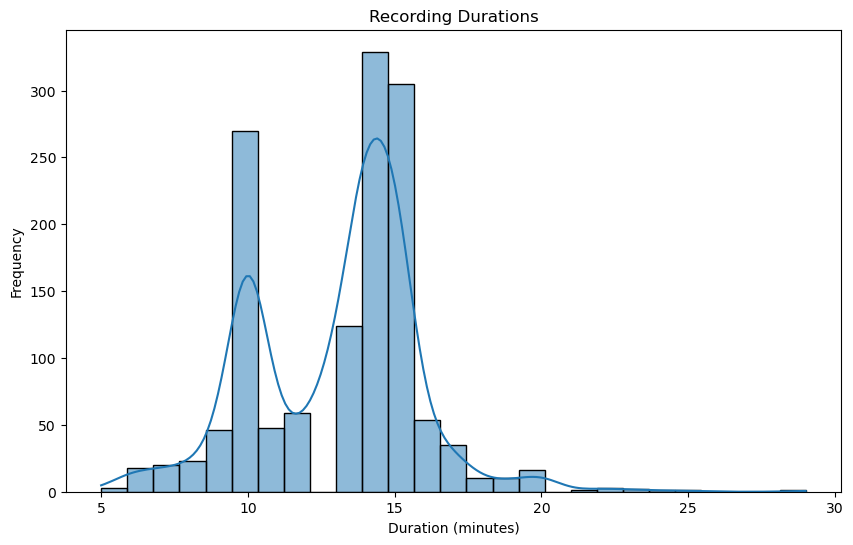

In [ ]:
# Plot histogram of recording durations
plt.figure(figsize=(10, 6))
sns.histplot(durations, kde=True)
plt.title('Recording Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')

In [ ]:
durations.describe()

count    1379.000000
mean       13.016679
std         2.799883
min         5.000000
25%        10.000000
50%        14.000000
75%        15.000000
max        29.000000
dtype: float64

The minimum recording length is 5 minutes, the maximum 29, and there are many recordings that are either 10 or 15 minutes long.